In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import ncx2
from simple_pe.waveforms import two_ecc_harms_SNR

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


Given a true value of the SNR $\hat{\rho}$ of a signal we expect to measure an observed SNR $\rho$ in stationary gaussian noise, where $\rho^2$ is distributed according to a non-central chi-squared distribution with two degrees of freedom and a non-centrality parameter equal to $\hat{\rho}^2$.

For the phase consistent SNR combination, we expect $\rho_{1,-1}^2$ to (approximately) follow a non-central chi-squared distribution with three degrees of freedom (one phase, two amplitude) and a non-centrality parameter equal to $\hat{\rho}_{1,-1}^2$.

In order to verify these statements, let's generate a bunch of samples corresponding to $z_1$, $z_{-1}$, and $z_{1,-1}$, where $z_x = \rho_x e^{i \phi_x}$.

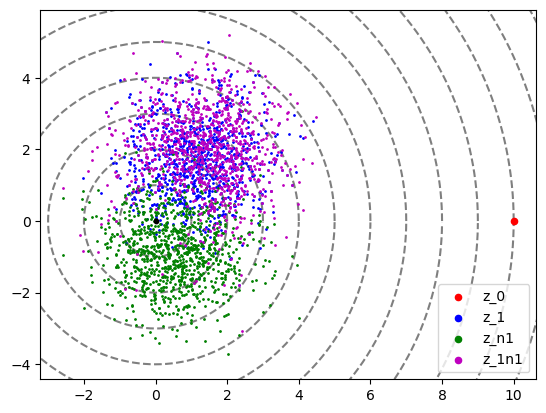

In [104]:
# Initial parameters
z_0 = 10*np.exp(1j*0)
z_1 = 2*np.exp(1j*1)
z_n1 = 1*np.exp(1j*-1)
z_1n1_abs, z_1n1_angle = two_ecc_harms_SNR({0: np.abs(z_0), 1: np.abs(z_1), -1: np.abs(z_n1)},
                                           {0: np.angle(z_0), 1: np.angle(z_1), -1: np.angle(z_n1)})
z_1n1 = np.abs(z_0)*z_1n1_abs*np.exp(1j*z_1n1_angle)

# Generate samples
samples_1 = np.random.normal(loc=np.real(z_1), size=10**6) + 1j*np.random.normal(loc=np.imag(z_1), size=10**6)
samples_n1 = np.random.normal(loc=np.real(z_n1), size=10**6) + 1j*np.random.normal(loc=np.imag(z_n1), size=10**6)
samples_1n1_abs, samples_1n1_angle = two_ecc_harms_SNR({0: np.full(len(samples_1), np.abs(z_0)), 1: np.abs(samples_1), -1: np.abs(samples_n1)},
                                                       {0: np.full(len(samples_1), np.angle(z_0)), 1: np.angle(samples_1), -1: np.angle(samples_n1)})
samples_1n1 = np.abs(z_0)*samples_1n1_abs*np.exp(1j*samples_1n1_angle)

# Plot samples
plt.gca().axis('equal')
plt.scatter(np.real(z_0), np.imag(z_0), c='r', s=20, label='z_0')
plt.scatter(np.real(samples_1[::1000]), np.imag(samples_1[::1000]), s=1, c='b')
plt.scatter(np.real(samples_n1[::1000]), np.imag(samples_n1[::1000]), s=1, c='g')
plt.scatter(np.real(samples_1n1[::1000]), np.imag(samples_1n1[::1000]), s=1, c='m')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.scatter(0, 0, c='k', s=10)
circle_angs = np.linspace(0, 2*np.pi, 1000, endpoint=False)
for i in range(1, 2*int(np.ceil(np.abs(z_0)))+1):
    circle = i*np.exp(1j*circle_angs)
    plt.plot(np.real(circle), np.imag(circle), c='k', ls='dashed', alpha=0.5, zorder=-1)
plt.scatter(xlim[1]*2, ylim[1]*2, c='b', s=20, label='z_1')
plt.scatter(xlim[1]*2, ylim[1]*2, c='g', s=20, label='z_n1')
plt.scatter(xlim[1]*2, ylim[1]*2, c='m', s=20, label='z_1n1')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.show()

We can now plot $\rho^2$ for each distribution and compare against predictions from the non-central chi-squared distribution.

In [113]:
np.max(np.abs(samples_list))

7.130453555654182

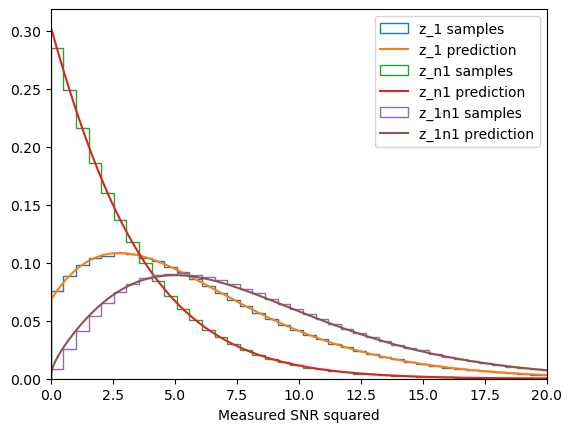

In [120]:
true_SNRs = [z_1, z_n1, z_1n1]
samples_list = [samples_1, samples_n1, samples_1n1]
dfs = [2,2,3]
legend = ['z_1', 'z_n1', 'z_1n1']

for i in range(len(true_SNRs)):
    _ = plt.hist(np.abs(samples_list[i])**2, histtype='step', density=True, bins=100, range=(0, np.max(np.abs(samples_list))**2), label=f'{legend[i]} samples')
    m_SNR = np.linspace(1e-10, np.max(np.abs(samples_list[i])), 1001)
    pdf = ncx2.pdf(m_SNR**2, dfs[i], np.abs(true_SNRs[i])**2)
    plt.plot(m_SNR**2, pdf, label=f'{legend[i]} prediction')
plt.legend()
plt.xlabel('Measured SNR squared')
plt.xlim(0, 20)
plt.show()

In [22]:
# Gets 90% confidence bounds (in SNR^2 space) with x% cutoff from left
def get_CI(rv, x, CI=0.9):
    q = np.array([x, x+CI])
    CI_bounds = rv.ppf(q)
    return CI_bounds

# Gets 90% confidence bounds (in SNR space) with shortest possible distance (in SNR**2 space)
def get_hpd(rv, CI=0.9):

    min_result = minimize(lambda x: abs(np.diff(get_CI(rv, x[0], CI=CI))[0]), (1-CI)/2, bounds=[(0,1-CI)])
    min_x = min_result['x'][0]

    return np.sqrt(get_CI(rv, (1-CI)/2, CI=CI))

Text(0, 0.5, 'Expected SNR')

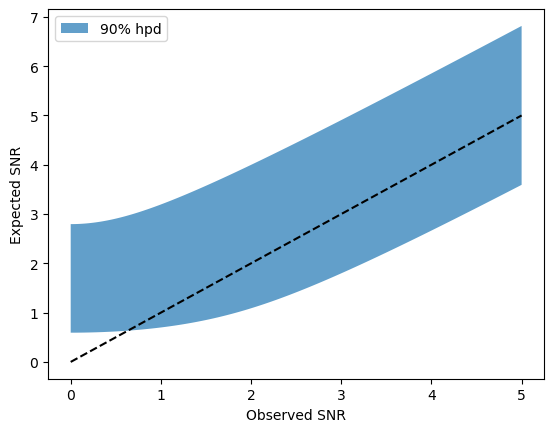

In [23]:
# Calculate 90% hpd bounds for dense array of observed SNRs
hpd_bounds = []
obs_arr = np.linspace(0, 5, 201)
for obs in obs_arr:
    rv = ncx2(3, obs**2)
    hpd_bounds.append(get_hpd(rv, CI=0.9))
hpd_bounds = np.array(hpd_bounds)

# Make plot
plt.fill_between(obs_arr, hpd_bounds.T[0], hpd_bounds.T[1], alpha=0.7, label='90% hpd')
plt.plot(obs_arr, obs_arr, c='k', ls='dashed', zorder=3)
plt.legend(loc='upper left')
plt.xlabel('Observed SNR')
plt.ylabel('Expected SNR')

Text(0, 0.5, 'Expected SNR')

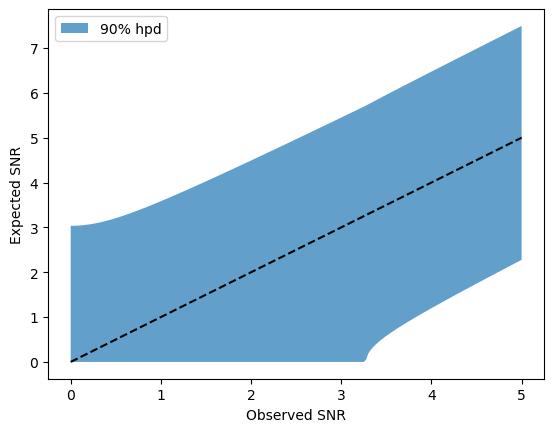

In [20]:
# Calculate 90% hpd bounds for dense array of observed SNRs
hpd_bounds = []
obs_arr = np.linspace(0, 5, 201)
for obs in obs_arr:
    rv = ncx2(2, obs**2)
    hpd_bounds.append(get_hpd(rv, CI=0.99))
hpd_bounds = np.array(hpd_bounds)

# Make plot
plt.fill_between(obs_arr, hpd_bounds.T[0], hpd_bounds.T[1], alpha=0.7, label='90% hpd')
plt.plot(obs_arr, obs_arr, c='k', ls='dashed', zorder=3)
plt.legend(loc='upper left')
plt.xlabel('Observed SNR')
plt.ylabel('Expected SNR')

In [16]:
rv = ncx2(2, 3**2)
print(get_hpd(rv, CI=0.99))

[1.58993203        nan]
